In [1]:
%%capture
!pip install torchsummary
!pip install "gymnasium[atari, accept-rom-license]"
!pip install moviepy
!pip install moviepy --upgrade
!pip install ffmpeg --upgrade

# Import Module

In [2]:
import ale_py
import shimmy
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import time

import cv2
import numpy as np

from collections import namedtuple, deque
from itertools import count
from IPython.display import clear_output, display
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(gym.__version__)

is_ipython= "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

cuda
0.29.1


# Setup environment

In [3]:
"""
Game: BreakOut
_ Actions: 4 (0: NOOP, 1: FIRE, 2: RIGHT, 3: LEFT)
_ Observation (Frame): Box(0, 255, (210, 160, 3), uint8) --> Resie+ Stack (4xFrames): Box(0,255,(4, 88, 80, 3), uint8)
  + Box: Biểu diễn space hay container mà chứa frame hay observation. Trong môi trường Gym, Box thường được hiểu là một continuous space mà trong đó các phần tử (pixel trong trường hợp image) có bất kì
giá trị nào trong một khoảng cho trước
  + (0, 255.. :Khoảng giá trị mà observation/frame có thể có (trong case này là 0->255 giá trị pixel)
  + (210, 160, 3): Khung hình, size của observation/frame. (Height, Width, Channel)
  + uint8: data type của giá trị của frame, 8-bit unsigned integer data type
_ Reward: Tham khảo trang sau: https://atariage.com/manual_html_page.php?SoftwareID=889
"""

def observation_preproc(frame):
    """Crop ảnh lấy khung game """
    cropped_frame = frame[35:195, 7:153]/255
    
    return cropped_frame
    

STACK_NUM= 4
RESIZE_HEIGHT= 84
RESIZE_WIDTH= 84

# Make game environment
print("Creating Environment")
env= gym.make("ALE/Breakout-v5", render_mode= 'rgb_array')
print(f"Original environment observation shape: {env.observation_space.shape}")
env= gym.wrappers.GrayScaleObservation(env)
print(f"Gray scaled environment observation: {env.observation_space.shape}")
env= gym.wrappers.TransformObservation(env, observation_preproc)
print(f"Transformed environment observation: {env.observation_space.shape}")
env= gym.wrappers.ResizeObservation(env, (RESIZE_HEIGHT, RESIZE_WIDTH))
print(f"Resized environment observation: {env.observation_space.shape}")
env= gym.wrappers.FrameStack(env, STACK_NUM)
print(f"Frames stacked environment observation: {env.observation_space.shape}")

# Visualize non stack observation
#observation = env.reset(seed=random.randint(0, 2**24))  # Get an initial observation
#print(f"Shape of transformed observation: {observation[0].shape}")
#print(observation[0])
#plt.imshow(observation[0], cmap= 'gray')  # Display in grayscale
#plt.show()

Creating Environment


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Original environment observation shape: (210, 160, 3)
Gray scaled environment observation: (210, 160)
Transformed environment observation: (210, 160)
Resized environment observation: (84, 84)
Frames stacked environment observation: (4, 84, 84)


# Replay Memory

In [4]:
Transition= namedtuple('Transistion', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory= deque([], maxlen= capacity) #deque (pronounced as deck) is a list-like object in Python but support pop and insrert both size with effiency

    def push(self, *args):
        """
        Lưu tuple transition vào deque memory, deque có dạng là list của tuples
        memory= deque([Transition('state', 'action', 'next_state', 'reward'), Transition('state', 'action', 'next_state', 'reward'), ...], maxlen= capacity)
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Hàm dưới random chọn batch_size tuples trong deque
        return có dạng [Transition('state', 'action', 'next_state', 'reward'), Transition('state', 'action', 'next_state', 'reward'), ...] với len= batch_size
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Deep Q Network

## RGB Environment CNN

In [5]:
# Vì ta đang xử ký tín hiệu ảnh (màn hình Arcade) nên ta cần dùng tích chập
class DQN(nn.Module):
    def __init__(self, n_stack, n_actions):
        super(DQN, self).__init__()
            
        self.conv_layer1= nn.Sequential(
            nn.Conv2d(in_channels= n_stack, out_channels= 32, kernel_size= 8, stride= 4),
            nn.ReLU(inplace= True)
        )

        self.conv_layer2= nn.Sequential(
            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 4, stride= 2),
            nn.ReLU(inplace= True)
        )

        self.conv_layer3= nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1),
            nn.ReLU(inplace= True)
        )
        
        self.relu= nn.ReLU(inplace= True)
        
        self.flatten= nn.Flatten()
        self.layer1= nn.Linear(7*7*64, 512)
        self.layer2= nn.Linear(512, n_actions)

    def forward(self, x):
        x= self.conv_layer1(x)
        x= self.conv_layer2(x)
        x= self.conv_layer3(x)

        x= self.flatten(x)

        x= self.relu(self.layer1(x))
        x= self.layer2(x)

        return x

# Hyperparameters

In [6]:
# BATCH_SIZE là số transitions được sample trong replay buffer
# GAMMA là discount factor
# EPS_START là giá trị ban đầu của epsilon
# EPS_END là giá trị sau của epsilon]
# EPS_DECAY sẽ điều khiển giá trị giảm lũy thừa (rate of exponetial decay) của epsilon, càng cao nghĩa là giảm càng chậm
# TAU là giá trị update của target network
# LR là learning rate của AdamW optimizer

BATCH_SIZE= 128
GAMMA= 0.99
EPS_START= 1.0
EPS_END= 0.01
EPS_DECAY= 100000
TAU= 0.005
LR= 1e-4
TARGET_UPDATE_STEP= 500


n_actions= env.action_space.n
obs_shape= env.observation_space.shape[0]

# RGB Environment
policy_net= DQN(n_stack= STACK_NUM, n_actions= n_actions).to(device)
target_net= DQN(n_stack= STACK_NUM, n_actions= n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer= optim.AdamW(policy_net.parameters(), lr= LR, amsgrad= True)
memory= ReplayMemory(10000)

steps_done= 0

def select_action(state):
    #print(f'In the select_action, shape is: {state.shape}')
    """
    Hàm select_action sẽ chọn action dựa theo epsilon greedy policy. Một cách đơn giản, ta sẽ đôi khi dùng model để chọn action, nhưng đôi khi ta chỉ lấy mẫu một cách thống nhất (uniformly)
    Xác suất chọn random action sẽ start từ EPS_START và decay dần theo hàm mũ theo đến EPS_END. EPS_DECAY sẽ điều khiển độ giảm.
    """
    global steps_done # Set variable trong function này phản ánh đến variable ngoài function
    global fire_ball 
    
    sample= random.random() # Random giá trị bất kì từ 0 -> 1
    eps_threshold= EPS_END+ (EPS_START - EPS_END)* math.exp(-1.* steps_done/ EPS_DECAY) # Tính giá trị epsilon greedy tại step hiện tại

    steps_done+= 1
    if fire_ball:
        fire_ball= False
        action= torch.tensor([[1]], device= device, dtype= torch.long)
        #print(f"Proceed with ramdom action, choose action {action}")
        return action
    elif sample> eps_threshold:
        """
        Nếu giá trị random(sample) > giá trị epsilon thì agent sẽ select action từ policy model, không thì random action. Khi về cuối epsilon càng giảm, agent sẽ càng chú trọng việc thực thi
        theo policy hơn là random
        """
        with torch.no_grad():
            """
            Example:
            1. Output từ policy net: [0.5, 0.8, 0.3, 0.9]
            2. Sau max, dimension 1: 0.9
            3. Sau indices (lấy index của max): 3
            4. Sau view(1,1): [[3]]
            """
            action= policy_net(state).max(dim= 1).indices.view(1,1)
            #print(f"Proceed with Policy, choose action {action}")
            return action
    else:
        action= torch.tensor([[env.action_space.sample()]], device= device, dtype= torch.long)
        #print(f"Proceed with ramdom action, choose action {action}")
        return action

episode_durations= []
episode_rewards= []

def plot_durations(show_result= False):
    """
    Function giúp plot duration của episodes, cùng với trung bình của 100 episodes gần nhất.
    """
    plt.figure(1)
    durations_t= torch.tensor(episode_durations, dtype= torch.float) #Convert list gồm durations của nhiều episode thành tensors.
    reward_t= torch.tensor(episode_rewards, dtype= torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf() # Clear các figures hiện có
        plt.title('Training...')

    plt.subplot(211)
    plt.ylabel('Reward')
    plt.plot(reward_t.numpy())
    if len(durations_t)>= 100:
        means= reward_t.unfold(0, 100, 1).mean(1).view(-1)
        means= torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy()) # Plot thêm trung bình của 100 episode gần nhất
    
    plt.subplot(212)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy()) # Plot duration theo từng episode
    # Lấy avg của 100 episode và plot
    if len(durations_t)>= 100:
        means= durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means= torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy()) # Plot thêm trung bình của 100 episode gần nhất

    plt.pause(0.001) # Delay để update
    if is_ipython:
        if not show_result:
            display.display(plt.gcf()) # plt.gcf: Lấy figure hiện tại
            display.clear_output(wait= True)
        else:
            display.display(plt.gcf())

# Training Loop

In [7]:
def optimize_model():
    if len(memory)< BATCH_SIZE:
        return
    #print("Gather enough data, start training...")
    transition= memory.sample(BATCH_SIZE) #Dùng method sample trong class ReplayMemory để chọn random BATCH_SIZE trong memory

    """
    Tạo batch để store random BATCH_SIZE transition dưới dạng
    Transition('state'= (s1, s2, ..), 'action'= (a1, a2, ..), 'next_state'= (s2, s3, ..), 'reward'= (r1, r2, ..)))
    """
    batch= Transition(*zip(*transition))

    """
    Tạo một tensor tuple True False, nơi state tiếp tồn tại thì True. Ngược lại nếu state tiếp theo là terminate state hay end thì False
    """
    non_final_mask= torch.tensor(
        tuple(
            map(lambda s: s is not None, batch.next_state)
        ), device= device, dtype= torch.bool
    )

    """
    Stack các state tiếp theo lại với nhau, chỉ các state không phải terminated state hay end state
    """
    non_final_next_state= torch.cat([s for s in batch.next_state if s is not None]).to(device)

    state_batch= torch.cat(batch.state) # Dimension (batch_size, 4, 84, 84)
    action_batch= torch.cat(batch.action) # Dimension (batch_size, 1)
    reward_batch= torch.cat(batch.reward) # Dimension (batch_size, 1)

    """
    Tìm Q_value (Q(state, action)) cho batch
    Ở đây output của model sẽ là Q value của state đó ứng với tất cả các actions có thể có (4):
    Lấy ví dụ batch_size= 2
    output = [
        [Q(state1, action1), Q(state1, action2), Q(state1, action3), Q(state1, action4)],
        [Q(state2, action1), Q(state2, action2), Q(state2, action3), Q(state2, action4)]
    ]

    action_batch = [
        [3],  # Action indices for state1: action4
        [1]   # Action indices for state2: action2
    ]

    Q_value= [
        Q(state1, action4),  # From output[0](1st instance trong batch) [3] (index số 4)
        Q(state2, action2)   # From output[1] (2nd instance tron batch) [1] (index số 2)
    ]

    """
    Q_value= policy_net(state_batch).gather(1, action_batch)

    """
    Khởi tạo Q_hat_next_state là tensor list 0
    """
    Q_hat_next_state= torch.zeros(BATCH_SIZE, device= device)
    with torch.no_grad():
        """
        Tính Q_hat_next_state chỉ tại nơi True, nghĩa là nơi có state kế tiếp
        """
        Q_hat_next_state[non_final_mask]= target_net(non_final_next_state).max(dim= 1).values

    """
    Tìm Q-target
    """
    Q_target= reward_batch+ GAMMA*Q_hat_next_state

    # Tính hàm loss
    criterion= nn.SmoothL1Loss()
    loss= criterion(Q_value, Q_target.unsqueeze(1))

    # Tối ưu model
    optimizer.zero_grad()
    loss.backward()

    """
    Gradient Clipping, dùng để giảm thiểu exploding gradient. Nhất là trong trường hợp mà gradient trong backpropagation có thể rất lớn.
    Điều này có thể xảy ra trong deep neural network, đặc biệt là trong reinforcement learning, nơi mà giá trị estimate có thể bị phân kỳ hay dao động lớn.
    """
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1000)
    optimizer.step()
    #print("Optimize model hoàn tất")

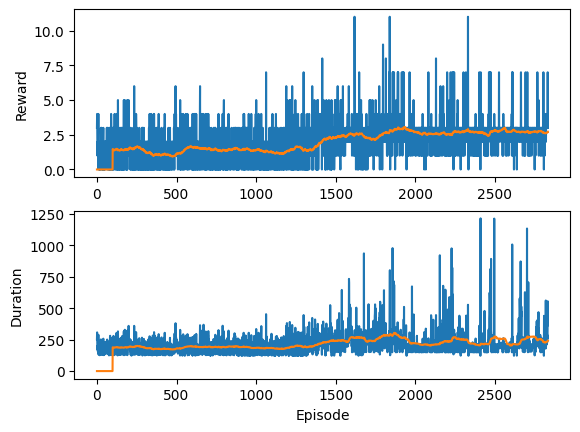

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available: 
    num_episode= 1000000
else: 
    num_episode= 50

print(f"Training on total of {num_episode} episodes")

for espisode in range(num_episode):
    fire_ball= True
    state, info= env.reset(seed=random.randint(0, 2**24))
    state= torch.tensor(state, dtype= torch.float32, device= device).unsqueeze(0)
    accumulate_reward= 0
    for t in count():
        action= select_action(state)
        observation, reward, terminated, truncated, info= env.step(action.item())
        done= terminated or truncated    
        reward= torch.tensor([reward], device= device)     
        
        if terminated:
            next_state= None
        else:
            next_state= torch.tensor(observation, dtype= torch.float32, device= device).unsqueeze(0)

        # Lưu transition vào memory
        memory.push(state, action, next_state, reward)

        # Đi đến state tiếp theo
        state= next_state

        # Train model
        optimize_model()

        # Update the Target net with soft update: θ′ ← τ θ + (1 −τ )θ′
        if t%TARGET_UPDATE_STEP== 0:
            target_net_state_dict= target_net.state_dict()
            policy_net_state_dict= policy_net.state_dict()

            for key in policy_net_state_dict:
                target_net_state_dict[key]= policy_net_state_dict[key]*TAU+ target_net_state_dict[key]*(1- TAU)
            target_net.load_state_dict(target_net_state_dict) # Update target model theo TAU
            #target_net.load_state_dict(policy_net_state_dict) # Update target model bằng policy model
        
        accumulate_reward+= reward
        
        if terminated:
            episode_durations.append(t+1)
            episode_rewards.append(accumulate_reward)
            plot_durations()
        
        if done:
            break

print("Complete")
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
version= 'v1'
game= 'BreakOut_v5'

torch.save(policy_net.state_dict(), f'save_models/policy_model_state_dict_{game}_{num_episode}episodes_{version}.pt')

# Play game based on Trained Policy

## Setup environment

In [3]:
STACK_NUM= 4
RESIZE_HEIGHT= 84
RESIZE_WIDTH= 84
env= gym.make("ALE/Breakout-v5", render_mode= 'rgb_array')
env= gym.wrappers.GrayScaleObservation(env)
env= gym.wrappers.ResizeObservation(env, (RESIZE_HEIGHT, RESIZE_WIDTH))
env= gym.wrappers.FrameStack(env, STACK_NUM)

n_actions= env.action_space.n
done, truncated = True, True

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


## Load model

In [4]:
from save_models import policy_model_BreakOut_v5_v1

policy_net= policy_model_BreakOut_v5_v1.load_model(height= RESIZE_HEIGHT, width= RESIZE_WIDTH, n_stack= STACK_NUM, n_actions= n_actions)
policy_net.eval()

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=3136, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=4, bias=True)
)

## Play game

In [5]:
env= gym.wrappers.RecordVideo(env= env, video_folder= "./video/", name_prefix= "BreakOutv5", episode_trigger= lambda x:x== 2)
env.metadata['render_fps']= 30
for episode in range(5):
    state, info= env.reset()
    env.start_video_recorder()
    done= False
    while not done:
        #plt.imshow(env.render())
        #display(plt.gcf())    
        #clear_output(wait=True)

        state_tensor= torch.tensor(state, dtype= torch.float32, device= device).unsqueeze(0)

        with torch.no_grad():
            action= policy_net(state_tensor).max(dim= 1).indices.view(1,1)
        
        #next_state, _, terminated, truncated, _ = env.step(env.action_space.sample())
        #print(action.item())
        next_state, _, terminated, truncated, _ = env.step(action.item())
        done= terminated or truncated
        #print(f"Done: {done}")
        state= next_state
        env.render()
    
    env.close()

/usr/local/lib/python3.9/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/DeepRL/BreakOut/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/tmp/ipykernel_180/2520329763.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state_tensor= torch.tensor(state, dtype= torch.float32, device= device).unsqueeze(0)


Moviepy - Building video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-0.mp4.
Moviepy - Writing video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-0.mp4
Moviepy - Building video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-1.mp4.
Moviepy - Writing video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-1.mp4
Moviepy - Building video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-2.mp4.
Moviepy - Writing video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-2.mp4
Moviepy - Building video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-2.mp4.
Moviepy - Writing video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-2.mp4
Moviepy - Building video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-3.mp4.
Moviepy - Writing video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-3.mp4
Moviepy - Building video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-4.mp4.
Moviepy - Writing video /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/DeepRL/BreakOut/video/BreakOutv5-episode-4.mp4


In [8]:
print("Done")

Done
